# RHF 核坐标梯度的 U 矩阵计算

之前我们已经讨论过 RHF 下的偶极矩与原子核坐标分量的能量导数计算了。这些导数的计算过程中，只需要使用矩阵的 Skeleton 导数即可。

但对于 MP2 方法而言，其原子核坐标分量的导数就不只需要 Skeleton 导数，还需要 U 矩阵的非占-占据部分了。这一节我们就来考察核坐标梯度下的 U 矩阵的求取，与 U 矩阵的一些性质。

## 准备工作

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff
from pyxdh.DerivOnce import GradSCF

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
gradh = GradSCF({"scf_eng": scf.RHF(mol)})

In [4]:
nmo, nao, natm, nocc, nvir = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir
so, sv, sa = gradh.so, gradh.sv, gradh.sa
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo

In [5]:
def grad_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {
        "scf_eng": scf_eng,
    }
    return GradSCF(config)

In [6]:
gradn = NucCoordDerivGenerator(mol, grad_generator)

但与之前文档不同的是，我们需要额外地给一个 `GradSCF` 实例 `gradh_nr`，它引入一个额外的选项 `rotation` (轨道旋转)，其值为 `False`：

In [7]:
gradh_nr = GradSCF({"scf_eng": scf.RHF(mol), "rotation": False})

其中 `nr` 意指 no rotation (无轨道旋转)。`gradh_nr` 与 `gradh` 只在处理 U 矩阵时会有不同，但作为最终结果的导数一般来说是相同的；在实例化 `GradSCF` 时，默认使用轨道旋转。

我们以后也会定义一些常用的导数量：

- `H_1_ao` $h_{\mu \nu}^\mathbb{A}$, `H_1_mo` $h_{pq}^\mathbb{A}$

- `S_1_ao` $S_{\mu \nu}^\mathbb{A}$, `S_1_mo` $S_{pq}^\mathbb{A}$

- `eri1_ao` $(\mu \nu | \kappa \lambda)^\mathbb{A}$, `eri1_mo` $(pq|rs)^\mathbb{A}$

其中的函数 `to_natm_3` 是将 `gradh` 或 `gradh_nr` 的导数矩阵的首个维度 (12) 变为原子数量乘上 3 (4, 3)。

In [8]:
def to_natm_3(mat: np.ndarray):
    shape = list(mat.shape)
    shape = [int(shape[0] / 3), 3] + shape[1:]
    return mat.reshape(shape)

In [9]:
H_1_ao, S_1_ao, eri1_ao = to_natm_3(gradh.H_1_ao), to_natm_3(gradh.S_1_ao), to_natm_3(gradh.eri1_ao)
H_1_mo, S_1_mo, eri1_mo = to_natm_3(gradh.H_1_mo), to_natm_3(gradh.S_1_mo), to_natm_3(gradh.eri1_mo)

## 数值导数求取 U 矩阵

### 没有经过“轨道旋转”的 U 矩阵

我们曾经提及过，U 矩阵定义如下：

$$
\frac{\partial C_{\mu p}}{\partial \mathbb{A}} = C_{\mu m} U_{m p}^\mathbb{A}
$$

这其实相当于矩阵乘法；如果我们想要反推出 $U_{mp}^{A_t}$ 的值，那么对 $C_{\mu m}$ 取逆即可：

$$
U_{mp}^\mathbb{A} = (\mathbf{C}^{-1})_{m \mu} \frac{\partial C_{\mu p}}{\partial \mathbb{A}}
$$

其中，没有经过“旋转” 的轨道系数 $C_{\mu m}$ 要求是 Canonical RHF 给出的系数矩阵，它至少同时满足 $F_{pq} = e_p \delta_{pq}$ 与 $C_{\mu p} S_{\mu \nu} C_{\nu q} = \delta_{pq}$ 两个对角矩阵的条件。

具体到核坐标梯度上来。我们首先定义系数矩阵导数 `nd_C` $\partial_{A_t}$：

In [10]:
nd_C = NumericDiff(gradn, lambda gradh: gradh.C).derivative.reshape((natm, 3, nao, nao))
nd_C.shape

(4, 3, 22, 22)

随后，我们就可以给出通过数值导数计算而来的 U 矩阵 `nd_U_1_nr` $U_{mp}^{A_t}$：

In [11]:
nd_U_1_nr = np.einsum("mu, Atup -> Atmp", np.linalg.inv(C), nd_C)
nd_U_1_nr.shape

(4, 3, 22, 22)

在 pyxdh 中，`gradh_nr.U_1` 代表的是没有经过旋转的解析 U 矩阵 $U_{pq}^{A_t}$。上述数值 U 矩阵 `nd_U_1_nr` 与该解析 U 矩阵 `gradh_nr.U_1` 的误差图是：

<IPython.core.display.Javascript object>


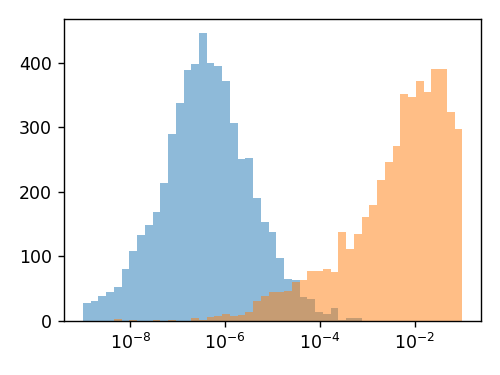

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_U_1_nr.ravel() - gradh_nr.U_1.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(gradh_nr.U_1.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

这样一张误差图与以前求 Skeleton 导数的误差图比起来，我们能明显感到，蓝色的条很明显地往较大的数值偏移，并且与橙色条有部分重叠；但我们仍然判断解析导数与数值导数比较接近。我们以后会经常见到这种情形，特别是矩阵或张量中含有关于 U 矩阵计算的情况时。

### 经过“轨道旋转”的 U 矩阵 (1) $\mathscr{U}_{pq}^{A_t}$ 的定义

上面提到，这是没有经过“轨道旋转”的 U 矩阵 $U_{pq}^{A_t}$，它对应的计算实例是 `gradh_nr`。而经过“轨道旋转”的 U 矩阵计算实例是 `gradh`，我们写为 $\mathscr{U}_{pq}^{A_t}$。一般地，$U_{pq}^{A_t} \neq \mathscr{U}_{pq}^{A_t}$：

<IPython.core.display.Javascript object>


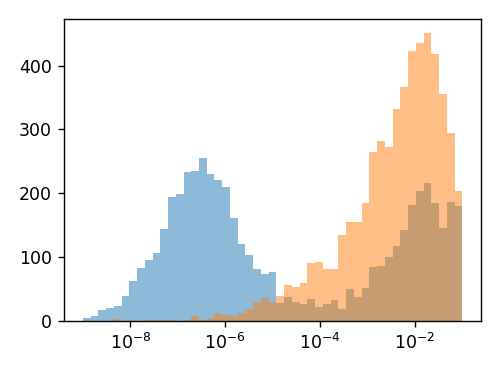

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_U_1_nr.ravel() - gradh.U_1.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(gradh.U_1.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

我们看到，我们通过数值导数所求出的 U 矩阵 $U_{pq}^{A_t}$ 和解析的、经过“轨道旋转”的 $\mathscr{U}_{pq}^{A_t}$ 的差值中，有许多超过了 $10^{-4}$ 量级；这表明两个矩阵差距太大，不能认为是近乎相同的。

事实上，经过某种“轨道旋转”(也可以理解为 non-Canonical RHF) 的 $\mathscr{U}_{pq}^{A_t}$ 并非按照一般 U 矩阵的定义；其定义如下：

$$
\begin{equation}
\mathscr{U}_{pq}^{A_t} = \left\{
\begin{matrix}
-\frac{1}{2} S_{ij}^{A_t} &\quad \textsf{occ-occ block} \\
-\frac{1}{2} S_{ab}^{A_t} &\quad \textsf{vir-vir block} \\
U_{ai}^{A_t} &\quad \textsf{vir-occ block} \\
U_{ia}^{A_t} &\quad \textsf{occ-vir block} \\
\end{matrix}
\right.
\end{equation}
$$

有意思的是，它在绝大多数情况下确实可以替代普通的 $U_{pq}^{A_t}$ 进行计算。关于这一点，我们会在以后遇到时逐个分析。我们现在需要知道的是，$U_{pq}^{A_t}$ 与 $\mathscr{U}_{pq}^{A_t}$ 同时满足的性质是：

$$
\begin{align}
U_{pq}^{A_t} + U_{qp}^{A_t} + S_{pq}^{A_t} &= 0 \\
\mathscr{U}_{pq}^{A_t} + \mathscr{U}_{qp}^{A_t} + S_{pq}^{A_t} &= 0
\end{align}
$$

定义 $\mathscr{U}_{pq}^{A_t}$ 并不是为了简化公式推导 (它的引入事实上还添了不少麻烦)，而是为了数值计算的稳定性和程序的便利。我们这一节会讨论到，若存在能量简并轨道，则没有进行“轨道旋转”的 $U_{pq}^{A_t}$ 矩阵将会产生奇点 (无穷大值)；因此需要使用“轨道旋转”了的矩阵 $\mathscr{U}_{pq}^{A_t}$ 来避免数值的不稳定性。因此，我们有必要事先介绍与引入 $\mathscr{U}_{pq}^{A_t}$。

### 经过“轨道旋转”的 U 矩阵 (2) $\mathscr{U}_{pq}^\mathbb{A}$ 与 $U_{pq}^\mathbb{A}$ 的关系

上面的讨论不仅对核坐标导数 $A_t$ 有意义，也可以推广到任意导数量 $\mathbb{A}$。这一小段我们就讨论 $\mathscr{U}_{pq}^\mathbb{A}$ 与 $U_{pq}^\mathbb{A}$ 的关系。

<div class="alert alert-warning">

**推导正确性存疑**

这里的推导并没有程序可以验证，也未必是正确的。

以后的文段中，不一定会应用这里的结论。一般来说，跳过这一小段的阅读不会对后续文段造成影响。

</div>

所谓“轨道旋转”，是指对分子轨道作旋转操作：

$$
\mathscr{C}_{\mu p'} = C_{\mu p} X_{pp'}
$$

或者，我们将上式写为矩阵乘法的形式：

$$
\boldsymbol{\mathscr{C}} = \mathbf{C} \mathbf{X}
$$

其中，我们称 $\mathbf{X}$ 为旋转矩阵，$p'$ 记号表示旋转过后的分子轨道角标。旋转矩阵具有以下特性：

- 为保证旋转后的系数矩阵仍然具有 $D_{\mu \nu} = \mathscr{C}_{\mu i'} \mathscr{C}_{\nu i'} = C_{\mu i} C_{\nu i}$ 的密度矩阵特性，$\mathbf{X}$ 必须是对角块矩阵 (block-diagonal)；或者说，$X_{ai'} = 0$ 且 $X_{ia'} = 0$；

- $\mathbf{X}$ 需要是一个正交矩阵，即 $\mathbf{X}^\dagger \mathbf{X} = \mathbf{1}$，即 $\mathbf{X}^\dagger = \mathbf{X}^{-1}$。

上述性质的一个推论是 (下面的 $\mathbf{S}$ 表示的是原子轨道下的重叠矩阵 $S_{\mu \nu}$)

$$
\boldsymbol{\mathscr{C}}^\dagger \mathbf{S} \boldsymbol{\mathscr{C}} = \mathbf{X}^\dagger \mathbf{C}^\dagger \mathbf{S} \mathbf{C} \mathbf{X} = \mathbf{X}^\dagger \mathbf{1} \mathbf{X} = \mathbf{1}
$$

上面的第三个等号成立依据是 $C_{\mu p} S_{\mu \nu} C_{\nu q} = \delta_{pq}$。

那么，我们就对 $\boldsymbol{\mathscr{C}}$ 作关于微扰量 $\mathbb{A}$ 的导数。我们首先定义旋转过后、再经过正交变换的 U 矩阵为 $\tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A}$：

$$
\frac{\partial \boldsymbol{\mathscr{C}}}{\partial \mathbb{A}} = \boldsymbol{\mathscr{C}} \tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A}
$$

那么，对 $\boldsymbol{\mathscr{C}} = \mathbf{C} \mathbf{X}$ 等式两边作关于 $\mathbb{A}$ 的偏导数，得到

$$
\boldsymbol{\mathscr{C}} \tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A} = \mathbf{C} \mathbf{U}^\mathbb{A} \mathbf{X} + \mathbf{C} \partial_\mathbb{A} \mathbf{X}
$$

对上式左乘 $\mathbf{C}^{-1}$，右乘 $\mathbf{X}^{-1} = \mathbf{X}^\dagger$，得到

$$
\mathbf{X} \tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A} \mathbf{X}^\dagger = \mathbf{U}^\mathbb{A} + (\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger
$$

我们定义上式为经过轨道旋转后的 $\boldsymbol{\mathscr{U}}^\mathbb{A}$，即

$$
\boldsymbol{\mathscr{U}}^\mathbb{A} = \mathbf{X} \tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A} \mathbf{X}^\dagger = \mathbf{U}^\mathbb{A} + (\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger
$$

之所以采用上式作为轨道旋转后的 U 矩阵的定义，而非 $\tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A}$，是因为我们想要保证下式的成立：

$$
\mathscr{U}_{pq}^\mathbb{A} + \mathscr{U}_{qp}^\mathbb{A} + S_{pq}^\mathbb{A} = 0
$$

也请读者注意，我们在 $\mathscr{C}_{\mu p'}$，进而在 $\tilde{\mathscr{U}}_{m' p'}^\mathbb{A}$ 使用的下标是旋转后的分子轨道 (即加一撇)；但在 $\mathscr{U}_{mp}^\mathbb{A}$ 中却使用的是普通的、为旋转的分子轨道角标 (即没有撇)。

下面我们从 $\boldsymbol{\mathscr{C}}^\dagger \mathbf{S} \boldsymbol{\mathscr{C}} = \mathbf{1}$ 出发，验证该等式。对该式两边求关于 $\mathbb{A}$ 的偏导，得到

$$
\begin{align}
\mathbf{0} &= \frac{\partial \boldsymbol{\mathscr{C}}^\dagger}{\partial \mathbb{A}} \mathbf{S} \boldsymbol{\mathscr{C}} + \boldsymbol{\mathscr{C}}^\dagger \frac{\partial \mathbf{S}}{\partial \mathbb{A}} \boldsymbol{\mathscr{C}} + \boldsymbol{\mathscr{C}}^\dagger \mathbf{S} \frac{\partial \boldsymbol{\mathscr{C}}}{\partial \mathbb{A}} \\
&= \tilde{\boldsymbol{\mathscr{U}}}^{\mathbb{A} \dagger} \boldsymbol{\mathscr{C}}^\dagger \mathbf{S} \boldsymbol{\mathscr{C}} + \boldsymbol{\mathscr{C}}^\dagger \mathbf{S} \boldsymbol{\mathscr{C}} \tilde{\boldsymbol{\mathscr{U}}}^{\mathbb{A}} + \boldsymbol{\mathscr{C}}^\dagger \mathbf{S}^\mathbb{A} \boldsymbol{\mathscr{C}} \\
&= \tilde{\boldsymbol{\mathscr{U}}}^{\mathbb{A} \dagger} + \tilde{\boldsymbol{\mathscr{U}}}^{\mathbb{A}} + \boldsymbol{\mathscr{C}}^\dagger \mathbf{S}^\mathbb{A} \boldsymbol{\mathscr{C}}
\end{align}
$$

利用 $\mathbf{X}$ 为正交矩阵的特性，可以导出下述关系

$$
\tilde{\boldsymbol{\mathscr{U}}}^\mathbb{A} = \mathbf{X}^\dagger \boldsymbol{\mathscr{U}}^\mathbb{A} \mathbf{X}
$$

同时注意到，$\boldsymbol{\mathscr{C}} = \mathbf{C} \mathbf{X}$，那么

$$
\mathbf{0} = \mathbf{X}^\dagger \boldsymbol{\mathscr{U}}^{\mathbb{A} \dagger} \mathbf{X} + \mathbf{X}^\dagger \tilde{\boldsymbol{\mathscr{U}}}^{\mathbb{A}} \mathbf{X} + \mathbf{X}^\dagger \mathbf{C}^\dagger \mathbf{S}^\mathbb{A} \mathbf{C} \mathbf{X}
$$

对上式左乘 $\mathbf{X}$，右乘 $\mathbf{X}^\dagger$，得到

$$
\mathbf{0} = \boldsymbol{\mathscr{U}}^{\mathbb{A} \dagger} + \tilde{\boldsymbol{\mathscr{U}}}^{\mathbb{A}} + \mathbf{C}^\dagger \mathbf{S}^\mathbb{A} \mathbf{C}
$$

留意到上面的 $\boldsymbol{S}^\mathbb{A}$ 是原子轨道张量 $S_{\mu \nu}^\mathbb{A}$，因此与 $\mathbf{C}$ 作张量缩并后，得到的才是分子轨道张量 $S_{pq}^\mathbb{A}$。上式等价于 $\mathscr{U}_{pq}^\mathbb{A} + \mathscr{U}_{qp}^\mathbb{A} + S_{pq}^\mathbb{A} = 0$。

由于满足了上面的条件，因此我们称定义 $\boldsymbol{\mathscr{U}}^\mathbb{A} = \mathbf{U}^\mathbb{A} + (\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger$ 是合理的。

原则上，任何对角正交矩阵 $\mathbf{X}$ 都是允许的，并且 $\partial_\mathbb{A} \mathbf{X}$ 的性质在作者看来是无法控制 (具有相当大可变性) 的。因此，作者认为，在给定 $S_{pq}^\mathbb{A}$ 的情况下，对于任何满足 $\mathscr{U}_{pq}^\mathbb{A} + \mathscr{U}_{qp}^\mathbb{A} + S_{pq}^\mathbb{A} = 0$ 的 $\mathscr{U}_{pq}^\mathbb{A}$ 都是允许的。因此，为了程序计算的方便，我们可以作定义

$$
\begin{equation}
\mathscr{U}_{pq}^{A_t} = \left\{
\begin{matrix}
-\frac{1}{2} S_{ij}^{A_t} &\quad \textsf{occ-occ block} \\
-\frac{1}{2} S_{ab}^{A_t} &\quad \textsf{vir-vir block} \\
U_{ai}^{A_t} &\quad \textsf{vir-occ block} \\
U_{ia}^{A_t} &\quad \textsf{occ-vir block} \\
\end{matrix}
\right.
\end{equation}
$$

这看起来多此一举，但事实上，$\mathscr{U}_{pq}^\mathbb{A}$ 避免了 $U_{pq}^\mathbb{A}$ 所产生的很强的数值不稳定性。下图中，蓝色条展示的是 $U_{pq}^{A_t}$ 矩阵元值大小分布，橙色条展示的是 $\mathscr{U}_{pq}^{A_t}$ 矩阵元值大小分布。很明显能发现，橙色条的值普遍地比蓝色小一些。

<IPython.core.display.Javascript object>


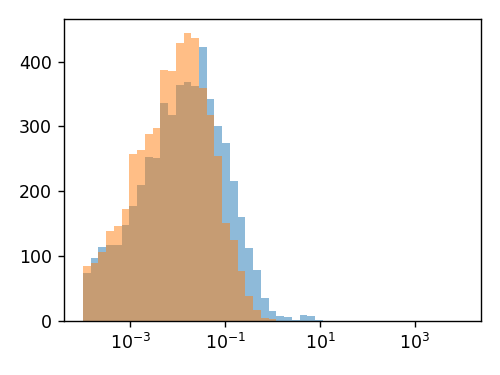

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(gradh_nr.U_1.ravel()), bins=np.logspace(np.log10(1e-4), np.log10(1e4), 50), alpha=0.5)
ax.hist(abs(gradh.U_1.ravel()), bins=np.logspace(np.log10(1e-4), np.log10(1e4), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

<div class="alert alert-info">

**任务 (1)**

我们之前用的都是非对称的双氧水分子；若现在考虑 $T_d$ 对称性的甲烷分子，请对未经“轨道旋转”的 $U_{\mu \nu}^{A_t}$ 和经过“轨道旋转”的 $\mathscr{U}_{\mu \nu}^{A_t}$ 绘制上述图像。

应当能预期看到蓝色的条延续到至少 $10^{10}$ 量级，意味着 $U_{\mu \nu}^{A_t}$ 在 $T_d$ 对称性的甲烷分子中，数值奇点问题要明显很多。原因会在后文提及。

</div>

最后，我们补充关于 $\boldsymbol{\mathscr{U}}^\mathbb{A} = \mathbf{U}^\mathbb{A} + (\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger$ 中，第二项 $(\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger$ 的讨论。另外一种导出该项的方法是

$$
\mathbf{0} = \frac{\partial \mathbf{1}}{\partial \mathbb{A}} = \frac{\partial (\mathbf{X} \mathbf{X}^\dagger)}{\partial \mathbb{A}} = (\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger + \mathbf{X} (\partial_\mathbb{A} \mathbf{X}^\dagger)
$$

因此，我们还可以写 $\boldsymbol{\mathscr{U}}^\mathbb{A} = \mathbf{U}^\mathbb{A} - \mathbf{X} (\partial_\mathbb{A} \mathbf{X}^\dagger)$。

我们说，$U_{ij}^\mathbb{A}$ 与 $U_{ab}^\mathbb{A}$ 一般来说不是对称矩阵；但我们定义的 $\mathscr{U}_{ij}^\mathbb{A} = - \frac{1}{2} S_{ij}^\mathbb{A}$ 与 $\mathscr{U}_{ab}^\mathbb{A} = - \frac{1}{2} S_{ab}^\mathbb{A}$ 则是对称矩阵。这种从非对称到对称的差距，应当就是通过 $(\partial_\mathbb{A} \mathbf{X}) \mathbf{X}^\dagger$ 这样一项来弥补的。但即使我们知道 $U_{pq}^\mathbb{A}$ 的形式，与 $\mathscr{U}_{pq}^\mathbb{A}$ 的定义，想要通过两者的关系直接求出 $\mathbf{X}$ 及其一阶导数 $\mathbf{X}^\mathbb{A}$，在作者看来是近乎不可能的。

## Fock 矩阵导数与 A 张量

在继续讨论 U 矩阵导数的解析求法之前，我们先对 Fock 矩阵导数相关的问题作叙述。

### Fock 矩阵导数 (1) Skeleton 导数

我们之前讨论过 Hamiltonian Core、重叠积分、ERI 积分的 Skeleton 导数；但我们尚没有讨论过 Fock 矩阵的 Skeleton 导数。

我们现在考虑 Fock 矩阵的导数。我们先回顾 Fock 矩阵的定义：

$$
F_{\mu \nu} = h_{\mu \nu} + (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{2} (\mu \kappa | \nu \lambda) D_{\kappa \lambda}
$$

所有与分子轨道无关的导数量的求和就是 Fock 矩阵的 Skeleton 导数 `F_1_ao`：

$$
\frac{\partial F_{\mu \nu}}{\partial A_t} \leftarrow F_{\mu \nu}^{A_t} = h_{\mu \nu}^{A_t} + (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{1}{2} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda}
$$

In [15]:
F_1_ao = (
    + H_1_ao
    + np.einsum("Atuvkl, kl -> Atuv", eri1_ao, D)
    - 0.5 * np.einsum("Atukvl, kl -> Atuv", eri1_ao, D)
)
F_1_ao.shape

(4, 3, 22, 22)

这也与 pyxdh 中对 $F_{\mu \nu}^{A_t}$ 的实现结果一致：

In [16]:
np.allclose(F_1_ao.ravel(), gradh.F_1_ao.ravel())

True

分子轨道下的 Fock Skeleton 导数 `F_1_mo` 也很容易地导出如下：

$$
F_{pq}^{A_t} = C_{\mu p} F_{\mu \nu}^{A_t} C_{\nu q}
$$

In [17]:
F_1_mo = np.einsum("up, Atuv, vq -> Atpq", C, F_1_ao, C)
F_1_mo.shape

(4, 3, 22, 22)

但是，需要注意到，不同于我们之前对 Hamiltonian Core、Overlap、ERI 积分的认识，Fock 矩阵的 Skeleton 导数 $F_{\mu \nu}^{A_t}$ 并不等价于 $\partial_{A_t} F_{\mu \nu}$；这也能从图像上看出端倪 (蓝色与橙色条纹相当接近)：

In [18]:
nd_F_0_ao = NumericDiff(gradn, lambda gradh: gradh.F_0_ao).derivative
nd_F_0_ao.shape

(12, 22, 22)

<IPython.core.display.Javascript object>


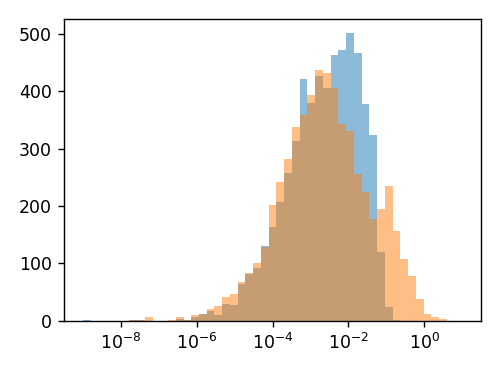

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_F_0_ao.ravel() - F_1_ao.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e1), 50), alpha=0.5)
ax.hist(abs(nd_F_0_ao.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e1), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

### Fock 矩阵导数 (2) U 导数与原子轨道下的 A 张量

正是因为 $F_{\mu \nu}$ 不像其他原子轨道积分，它是与密度有关的量；因此，我们将其导数与密度有关的部分抽提出来：

$$
\begin{align}
\frac{\partial F_{\mu \nu}}{\partial A_t} &\leftarrow (\mu \nu | \kappa \lambda) \frac{\partial D_{\kappa \lambda}}{\partial A_t} - \frac{1}{2} (\mu \kappa | \nu \lambda) \frac{\partial D_{\kappa \lambda}}{\partial A_t} \\
&= 2 \left( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa | \nu \lambda) \right) \big( C_{\kappa m} C_{\lambda i} + C_{\kappa i} C_{\lambda m} \big) U_{mi}^{A_t} \\
&= \big( 4 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) - (\mu \lambda | \kappa \nu) \big) C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
\end{align}
$$

<div class="alert alert-info">

**任务 (2)**

说明上述证明过程中的第 3 个等号为何成立。

</div>

为了符号上的便利，我们会定义原子轨道下的 A 张量

$$
A_{\mu \nu, \kappa \lambda} = 4 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) - (\mu \lambda | \kappa \nu)
$$

注意到尽管我们是通过求导得到的 A 张量；但 A 张量却没有包含任何导数的信息。因此，A 张量不论是原子核坐标梯度或是电场梯度，都完全相同。

那么，$\partial_{A_t} F_{\mu \nu}$ 中的 U 导数部分贡献可以记为

$$
\frac{\partial F_{\mu \nu}}{\partial A_t} \leftarrow A_{\mu \nu, \kappa \lambda} C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
$$

因此，总的原子轨道 Fock 矩阵导数可以写为

$$
\frac{\partial F_{\mu \nu}}{\partial A_t} = F_{\mu \nu}^{A_t} + A_{\mu \nu, \kappa \lambda} C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
$$

我们定义变量 `A_0_ao` $A_{\mu \nu, \kappa \lambda}$：

In [20]:
A_0_ao = 4 * eri0_ao - eri0_ao.swapaxes(-2, -3) - eri0_ao.swapaxes(-1, -3)
A_0_ao.shape

(22, 22, 22, 22)

我们假设已经知道了 $U_{pq}^{A_t}$ 可以通过 `gradh_nr.U_1` 调出，那么原子轨道下 Fock 矩阵 U 导数的贡献可以储存在变量 `F_U_ao` 中：

In [21]:
F_U_ao = np.einsum("uvkl, km, li, Atmi -> Atuv", A_0_ao, C, Co, to_natm_3(gradh_nr.U_1)[:, :, :, so])

我们不妨用图像验证一下，将 U 导数与 Skeleton 导数 (`F_1_ao` $F_{\mu \nu}^{A_t}$) 相加，是否与 `nd_F_0_ao` $\partial_{A_t} F_{\mu \nu}$ 近似相等：

<IPython.core.display.Javascript object>


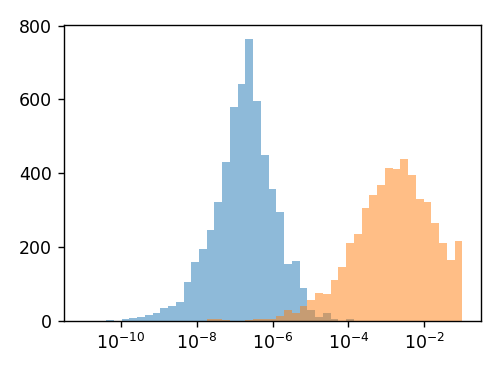

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(nd_F_0_ao.ravel() - (F_1_ao + F_U_ao).ravel()), bins=np.logspace(np.log10(1e-11), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_F_0_ao.ravel()), bins=np.logspace(np.log10(1e-11), np.log10(1e-1), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

### Fock 矩阵导数 (3) 分子轨道下的 A 张量

但一般的量化程序、以及 pyxdh 程序中，通常不使用上述的 `A_0_ao` $A_{\mu \nu, \kappa \lambda}$ 张量进行实际的量化计算；取而代之的是对任意矩阵 $X_{rs}$，计算 $A_{pq, rs} X_{rs}$。在此之前，我们先需要介绍一下分子轨道下的 A 张量 $A_{pq, rs}$。

张量 `A_0_mo` $A_{pq, rs}$ 定义如下：

$$
A_{pq, rs} = C_{\mu p} C_{\nu q} A_{\mu \nu, \kappa \lambda} C_{\kappa r} C_{\lambda s}
$$

这个定义与 ERI 积分有些相似。

In [23]:
A_0_mo = np.einsum("up, vq, uvkl, kr, ls -> pqrs", C, C, A_0_ao, C, C)
A_0_mo.shape

(22, 22, 22, 22)

引入该张量的缘由是我们会经常处理对分子轨道下 $F_{pq}$ 的导数 (Yamaguchi, p409, N.1)：

$$
\frac{\partial F_{pq}}{\partial {A_t}} = F_{pq}^{A_t} + A_{pq, mi} U_{mi}^{A_t} + F_{pm} U_{mq}^{A_t} + F_{mq} U_{mp}^{A_t}
$$

<div class="alert alert-info">

**任务 (3)**

证明上述等式。

</div>

<div class="alert alert-info">

**任务 (4)**

用程序求取 $\partial_{A_t} F_{pq}$ 的解析导数；并通过求出数值导数，来验证你的解析导数是否正确。你应当需要 `grad_nr.U_1` 来表示 U 矩阵 $U_{pq}^{A_t}$。

</div>

### A 张量 (1) pyxdh 程序说明

但对于 RHF (特别是 GGA) 方法而言，在内存中储存四维度的张量一般要尽力避免，因此通常会设计一个函数用于计算 $A_{pq, mi} U_{mi}^{A_t}$。在 pyxdh 中，这样一个函数是 `Ax0_Core`。

举一个例子。现在对于末尾两个维度是 $(n_\mathrm{MO}, n_\mathrm{MO})$ 的任意张量 (数值上或维度大小上，我们不妨定义为与 $U_{pq}^{A_t}$ 具有相同维度) `X` $X_{rs}^{A_t}$，我们可以用下述代码求出 `AX` $A_{pq, rs} X_{rs}^{A_t}$：

In [24]:
X = np.random.randn(natm, 3, nao, nao)

In [25]:
Ax0_Core = gradh.Ax0_Core
AX = Ax0_Core(sa, sa, sa, sa)(X)
AX.shape

(4, 3, 22, 22)

我们能发现，该结果可以用 `A_0_mo` 一样能导出：

In [26]:
np.allclose(
    np.einsum("pqrs, Atrs -> Atpq", A_0_mo, X),
    AX
)

True

现在我们详细讲讲 `Ax0_Core` 的使用。首先，`Ax0_Core` 本身是一个嵌套函数，它的输入是四个分割 (slice)，输出是一个函数，姑且称它为 `fx`：

In [27]:
Ax0_Core(sa, sa, sa, sa)

<function pyxdh.DerivOnce.deriv_once_scf.DerivOnceSCF.Ax0_Core.<locals>.fx(X_)>

函数 `fx` 的输入是除最后两维度外任意维度的张量，输出是 A 张量缩并后的结果。

随后我们说明这四个分割的意义。对于 `Ax0_Core(sa, sa, sa, sa)`，四个分割都是全轨道分割，意味着我们使用的张量是 $A_{pq, rs}$。但若针对 $A_{pq, mi} U_{mi}^{A_t}$ 而言，最后一个角标所代表的分割应当是占据轨道，因此 $A_{pq, mi} U_{mi}^{A_t}$ 在程序中应当表示为 `AU_nr`

In [28]:
AU_nr = Ax0_Core(sa, sa, sa, so)(to_natm_3(gradh_nr.U_1)[:, :, :, so])
AU_nr.shape

(4, 3, 22, 22)

我们以后还会经常遇到类似于 $A_{ai, bj} U_{bj}^{A_t}$ 的情况；对于这类张量缩并，我们需要用相应的轨道分割：

In [29]:
AU_nr = Ax0_Core(sv, so, sv, so)(to_natm_3(gradh_nr.U_1)[:, :, sv, so])
AU_nr.shape

(4, 3, 13, 9)

### A 张量 (2) PySCF 程序说明

在 pyxdh 的后期版本中，$A_{pq, rs} X_{rs}^\mathbb{A}$ 的实现是直接依靠 PySCF 的程序 `_gen_rhf_response` 实现的。该函数也是一个嵌套函数，其输出定义为 `resp`：

In [30]:
from pyscf.scf._response_functions import _gen_rhf_response
resp = _gen_rhf_response(gradh.scf_eng, mo_coeff=C, mo_occ=gradh.mo_occ, hermi=0)
resp

<function pyscf.scf._response_functions._gen_rhf_response.<locals>.vind(dm1)>

`resp` 是一个通过输入矩阵可以输出计算结果的函数；它的实际作用是生成

$$
\mathtt{resp}_{\mu \nu} [X_{\kappa \lambda}^\mathbb{A}] = \big( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa| \nu \lambda) \big) X_{\kappa \lambda}^\mathbb{A}
$$

但要求输入的 $X_{\mu \nu}^\mathbb{A}$ 的维度必须是 $(\mathbb{A}, \kappa, \lambda)$ 即必须是三维张量：

In [31]:
X = np.random.randn(5, nao, nao)

In [32]:
np.allclose(
    resp(X),
    + np.einsum("uvkl, Akl -> Auv", eri0_ao, X)
    - 0.5 * np.einsum("ukvl, Akl -> Auv", eri0_ao, X)
)

True

依靠该函数，我们就可以计算 $A_{pq, mi} U_{mi}^{A_t}$ 了。

<div class="alert alert-info">

**任务 (5)**

利用上面提及的 $\mathtt{resp}_{\mu \nu} [X_{\kappa \lambda}^\mathbb{A}]$，用程序求出 $A_{pq, mi} U_{mi}^{A_t}$ 并作验证；该式对 $m, i$ 角标求和。

</div>

最后我们指出，pyxdh 中的 `resp` 事实上是通过在 `_gen_rhf_response` 引入了参数 `hermi=1` 而非上面提到的 `hermi=0`；但这不影响我们这里的讨论。

## 解析 U 矩阵与 CP-HF 方程

### 分子轨道 Fock 矩阵导数与 U 矩阵

这一段中大部分时候所提及的 U 矩阵是未经“轨道旋转”的 U 矩阵 $U_{pq}^\mathbb{A}$。推导的具体细节可以参考 Yamaguchi 的书；我们也会在任务中作补充。

我们先回顾一下 Fock 矩阵全导数 (Yamaguchi, p433, W.1)：

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = F_{pq}^\mathbb{A} + A_{pq, mi} U_{mi}^\mathbb{A} + F_{pm} U_{mq}^\mathbb{A} + F_{mq} U_{mp}^\mathbb{A}
$$

我们知道，对于 Canonical 的 Fock 矩阵，有 $F_{pq} = \varepsilon_p \delta_{pq}$；因此，

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = F_{pq}^\mathbb{A} - S_{pq}^\mathbb{A} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A} + A_{pq, bj} U_{bj}^\mathbb{A} + (\varepsilon_p - \varepsilon_q) U_{pq}^\mathbb{A}
$$

<div class="alert alert-info">

**任务 (6)**

请证明上述等式，并用 `gradh_nr.U_1` 作为 $U_{pq}^{A_t}$，来验证当被求导量 $\mathbb{A}$ 为原子核坐标分量 $A_t$ 时，上述等式的正确性。

</div>

我们作补充定义上式中与 U 矩阵无关的所有项之和 `B_1` $B_{pq}^{A_t}$ (Yamaguchi, p437, X.3)：

$$
B_{pq}^\mathbb{A} = F_{pq}^\mathbb{A} - S_{pq}^\mathbb{A} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A}
$$

In [33]:
B_1 = (
    + F_1_mo
    - np.einsum("Atpq, q -> Atpq", S_1_mo, e)
    - 0.5 * Ax0_Core(sa, sa, so, so)(S_1_mo[:, :, so, so])
)

在 pyxdh 中也有 `B_1` property 来实现 $B_{pq}^{A_t}$：

In [34]:
np.allclose(B_1.ravel(), gradh.B_1.ravel())

True

那么

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = B_{pq}^\mathbb{A} + A_{pq, bj} U_{bj}^\mathbb{A} + (\varepsilon_p - \varepsilon_q) U_{pq}^\mathbb{A}
$$

### 非占-占据 U 矩阵 $U_{ai}^\mathbb{A}$：PySCF 库函数求解

根据 Canonical RHF 的定义，$F_{pq} = \varepsilon_{p} \delta_{pq}$；因而，非占-占据部分的 $F_{ai} = 0$。那么 (Yamaguchi, p437, X.1)

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^\mathbb{A} - A_{ai, bj} U_{bj}^\mathbb{A} = B_{ai}^\mathbb{A}
$$

上式也称为 CP-HF 方程 (Coupled Perturbed Hartree-Fock Equation)，我们可以通过该式求出解析的 $U_{pq}^\mathbb{A}$；其中上式对 $b, j$ 两个角标求和。我们需要对 CP-HF 方程有一定的掌握。

<div class="alert alert-info">

**演示 (1) 矩阵求逆求解 CP-HF 方程**

我们将会通过矩阵求逆的方法，从程序上获得解析的 $U_{ai}^{A_t}$；并与 `grad_nr.U_1` 或 `grad.U_1` 作核对。

</div>

但如之前所述，在一般的量化程序中，RHF 方法或 GGA 方法不适合在内存中储存四维度的张量。同时，如果对 $A_{ai, bj}$ 当作矩阵进行求逆的话，其计算消耗是处在 $O(o^3 v^3)$ 量级，是不可接受的；因此，演示 (1) 中的方法不被一般量化程序所接受。

在 pyxdh 中，求取 CP-HF 方程的方式仅仅是借用了 PySCF 的 CP-HF 程序 `cphf.solve`。

In [35]:
from pyscf.scf import cphf
cphf.solve

<function pyscf.scf.cphf.solve(fvind, mo_energy, mo_occ, h1, s1=None, max_cycle=20, tol=1e-09, hermi=False, verbose=2)>

其参数中，

- `fvind` 表示的是用于求取 $A_{ai, bj} U_{bj}^\mathbb{A}$ 的张量缩并函数，但要求 $U_{bj}^\mathbb{A}$ 必须是三维度而不能更高，即不能直接传入 $(A, t, b, j)$ 维度的 U 矩阵而要传入 $(A_t, b, j)$ 维度；

- `mo_energy` 表示分子轨道能量 $e_p$；

- `mo_occ` 表示分子轨道占据数 (在 RHF 中占据轨道为 2，非占轨道为 0)；

- `h1` 表示 CP-HF 方程等式等式右，即 $B_{ai}^\mathbb{A}$；注意它是 $B_{pq}^\mathbb{A}$ 在非占-占据的子张量，并且必须是 $(\mathbb{A}, a, i)$ 维度而不能是 $(A, t, a, i)$ 维度；

- `s1` 表示是否额外引入 $S_{pq}^\mathbb{A}$；但引入 `s1` 可能会使得程序输出较为复杂，pyxdh 中以及以后我们都不会引入该参数

其余的参数就不多作说明了。对于核坐标梯度，我们可以通过下述代码得到 $U_{ai}^{A_t}$：(留意到我们降低了 CP-HF 方程的收敛阈值；这是为了可以与 pyxdh 的结果能通过 np.allclose；pyxdh 默认的 CP-HF 方程的收敛阈值是 $10^{-6}$，比 PySCF 阈值要低很多)

In [36]:
U_1_ai = cphf.solve(
    Ax0_Core(sv, so, sv, so, in_cphf=True),
    e,
    gradh.scf_eng.mo_occ,
    B_1[:, :, sv, so].reshape(natm * 3, nvir, nocc),
    tol=1e-6,
)[0].reshape(natm, 3, nvir, nocc)

我们可以验证，它与 pyxdh 中的 U 矩阵近乎一致：

In [37]:
np.allclose(U_1_ai.ravel(), gradh.U_1[:, sv, so].ravel())

True

由于 U 矩阵中，其非占-占据分块 $U_{ai}^\mathbb{A}$ 的使用频率最高，因此它也会被特例地储存在 `U_1_vo` property 中。

In [38]:
np.allclose(U_1_ai.ravel(), gradh.U_1_vo.ravel())

True

<div class="alert alert-info">

**演示 (2) Newton-Krylov 求解 CP-HF 方程**

CP-HF 方程的求解可以看作是非线性方程的求解。我们将使用 SciPy 的 `scipy.optimize.newton_krylov`，求解 CP-HF 方程。

</div>

<div class="alert alert-info">

**演示 (3) CP-HF 方程求解效率与精度**

CP-HF 方程的求解是一个数值过程，伴随着收敛过程。因此，CP-HF 方程的求解存在着精度和效率问题。

我们将会展示与对比矩阵求逆、PySCF 库函数、SciPy 库函数三种方法的精度与效率。

</div>

### 占据-非占 U 矩阵 $U_{ia}^\mathbb{A}$

根据

$$
S_{ai}^\mathbb{A} + U_{ai}^\mathbb{A} + U_{ia}^\mathbb{A} = 0
$$

的关系，我们很容易地给出

$$
U_{ia}^\mathbb{A} = - S_{ai}^\mathbb{A} - U_{ai}^\mathbb{A}
$$

我们将 $U_{ia}^{A_t}$ 定义为 `U_1_ia`：

In [39]:
U_1_ia = (- S_1_mo[:, :, sv, so] - U_1_ai).swapaxes(-1, -2)

我们也可以验证，它与 pyxdh U 矩阵中对应的部分是完全相等的：

In [40]:
np.allclose(U_1_ia.ravel(), gradh.U_1[:, so, sv].ravel())

True

### 占据-占据 U 矩阵 $U_{ij}^\mathbb{A}$ 与非占-非占 $U_{ab}^\mathbb{A}$ U 矩阵

但我们注意到，我们刚才仅仅是求取了 U 矩阵中的非占-占据部分 $U_{ai}^\mathbb{A}$。现在我们来处理剩下的矩阵分块。由于占据-占据 $U_{ij}^\mathbb{A}$ 与非占-非占 $U_{ab}^\mathbb{A}$ U 矩阵的处理方式是一样的，我们先把重心放在 $U_{ij}^\mathbb{A}$ 的求取上。

我们再次回顾 $F_{pq}^\mathbb{A}$ 的全导数。我们利用 $i \neq j$ 时，$F_{ij} = 0$ 的特性，给出

$$
- (\varepsilon_i - \varepsilon_j) U_{ij}^\mathbb{A} - A_{ij, bk} U_{bk}^\mathbb{A} = B_{ij}^\mathbb{A} \quad (i \neq j)
$$

我们就会注意到，既然 $U_{bk}^\mathbb{A}$ 是 U 矩阵的非占-占据部分是已知的，那么上式中唯一未知的量是 $U_{ij}^\mathbb{A}$。其求取方式也很简单：

$$
U_{ij}^\mathbb{A} = - \frac{B_{ij}^\mathbb{A} + A_{ij, bk} U_{bk}^\mathbb{A}}{\varepsilon_i - \varepsilon_j} \quad (i \neq j)
$$

我们将上述矩阵写作 `U_1_oo`：(矩阵维度可能鬼畜了一些 $=\omega=$)

In [41]:
U_1_oo = - (B_1[:, :, so, so] + Ax0_Core(so, so, sv, so)(U_1_ai)) / (eo[:, None] - eo[None, :])
U_1_oo.shape

(4, 3, 9, 9)

现在我们不妨看一下上述矩阵在索引为 0 的原子的 $x$ 坐标分量的情况：

In [42]:
U_1_oo[0, 0]

array([[    -inf, -0.00061, -0.0003 , -0.00087,  0.00001, -0.01349,  0.00083, -0.00057,  0.00145],
       [ 0.00059,      inf,  0.0003 ,  0.00063,  0.00011,  0.00517,  0.00016, -0.00017, -0.00709],
       [-0.00006, -0.00004,      inf, -0.02338, -0.00143, -0.02703,  0.00618, -0.00427, -0.07226],
       [ 0.00005, -0.00003,  0.02062,      inf, -0.00955, -0.21278,  0.01507, -0.0061 ,  0.06499],
       [-0.     ,  0.00001,  0.0011 ,  0.00538,      inf, -0.13363,  0.01578,  0.00104,  0.12086],
       [ 0.00084, -0.00028,  0.01215,  0.08071,  0.10916,      inf,  0.37053, -0.08701,  0.37218],
       [ 0.00004,  0.00001, -0.0021 , -0.00429, -0.01133, -0.36241,      inf,  0.02962, -0.52665],
       [-0.00001, -0.     ,  0.0011 ,  0.00099, -0.00199,  0.08254, -0.02752,      inf,  0.22311],
       [-0.00012,  0.00032,  0.02126, -0.02906, -0.07755, -0.31986,  0.42284, -0.19189,      inf]])

之所以对角元上会出现 $\inf$，是因为当 $i = j$ 时，作为分母的 $\varepsilon_i - \varepsilon_j = 0$，因此导致该处的值无法定义。

解决上述问题的方法，仍然是利用 $S_{pq}^\mathbb{A} + U_{pq}^\mathbb{A} + U_{pq}^\mathbb{A} = 0$ 的特性。当 $p = q = i$ 时，我们应当能求得

$$
U_{ii}^\mathbb{A} = - \frac{1}{2} S_{ii}^\mathbb{A}
$$

In [43]:
for A in range(natm):
    for t in range(3):
        for i in range(nocc):
            U_1_oo[A, t, i, i] = - 0.5 * S_1_mo[A, t, i, i]

现在我们再看 `U_1_oo`：

In [44]:
U_1_oo[0, 0]

array([[-0.00003, -0.00061, -0.0003 , -0.00087,  0.00001, -0.01349,  0.00083, -0.00057,  0.00145],
       [ 0.00059, -0.     ,  0.0003 ,  0.00063,  0.00011,  0.00517,  0.00016, -0.00017, -0.00709],
       [-0.00006, -0.00004,  0.00051, -0.02338, -0.00143, -0.02703,  0.00618, -0.00427, -0.07226],
       [ 0.00005, -0.00003,  0.02062, -0.01012, -0.00955, -0.21278,  0.01507, -0.0061 ,  0.06499],
       [-0.     ,  0.00001,  0.0011 ,  0.00538, -0.00088, -0.13363,  0.01578,  0.00104,  0.12086],
       [ 0.00084, -0.00028,  0.01215,  0.08071,  0.10916, -0.01346,  0.37053, -0.08701,  0.37218],
       [ 0.00004,  0.00001, -0.0021 , -0.00429, -0.01133, -0.36241, -0.00629,  0.02962, -0.52665],
       [-0.00001, -0.     ,  0.0011 ,  0.00099, -0.00199,  0.08254, -0.02752, -0.00003,  0.22311],
       [-0.00012,  0.00032,  0.02126, -0.02906, -0.07755, -0.31986,  0.42284, -0.19189, -0.03002]])

它与 pyxdh 中 U 矩阵的结果也相同 (注意需要用 `grad_nr` 调出未经“轨道旋转”的 U 矩阵，因为经过轨道旋转的 $\mathscr{U}_{ij}^\mathbb{A} = - \frac{1}{2} S_{ij}^\mathbb{A}$)：

In [45]:
np.allclose(U_1_oo.ravel(), gradh_nr.U_1[:, so, so].ravel())

True

<div class="alert alert-info">

**任务 (7)**

请用程序求出 `U_1_vv` $U_{ab}^{A_t}$，并与 pyxdh 中对应的 U 矩阵结果作核对。

</div>

至此，我们就完成了所有 RHF 下的 U 矩阵的计算了。

## 简单总结

首先，我们在 [数值导数求取 U 矩阵](#数值导数求取-U-矩阵) 一小节中，利用

$$
U_{mp}^\mathbb{A} = (\mathbf{C}^{-1})_{m \mu} \frac{\partial C_{\mu p}}{\partial \mathbb{A}}
$$

求出数值的 U 矩阵 $U_{pq}^\mathbb{A}$ `U_1_nr`，并与 pyxdh 中解析的 U 矩阵 `grad_nr.U_1` 做了对比。同时我们意识到 $U_{pq}^\mathbb{A}$ 存在数值问题，因此我们经常会使用 $\mathscr{U}_{pq}^\mathbb{A}$ `grad.U_1` 替代 Canonical RHF 轨道下导出的 U 矩阵，并对 $U_{pq}^\mathbb{A}$ 与 $\mathscr{U}_{pq}^\mathbb{A}$ 做了理论上的比较。

随后，在 [Fock 矩阵导数与 A 张量](#Fock-矩阵导数与-A-张量) 一小节中，我们引入了分子轨道下 A 张量。其引入的缘起是

$$
\frac{\partial F_{pq}}{\partial {A_t}} = F_{pq}^{A_t} + A_{pq, mi} U_{mi}^{A_t} + F_{pm} U_{mq}^{A_t} + F_{mq} U_{mp}^{A_t}
$$

其在 RHF 下的定义是

$$
A_{pq, rs} = 4 (pq|rs) - (pr|qs) - (ps|qr)
$$

但是出于内存存储的考量，我们定义了用于计算 $A_{pq, rs} X_{rs}^\mathbb{A}$ 的程序 `Ax0_Core`。

A 张量的主要用途是 [实现 CP-HF 方程](#解析-U-矩阵与-CP-HF-方程)：

$$
- (\varepsilon_i - \varepsilon_j) U_{ij}^\mathbb{A} - A_{ij, bk} U_{bk}^\mathbb{A} = B_{ij}^\mathbb{A} \quad (i \neq j)
$$

我们随后介绍了 PySCF 库函数求解 CP-HF 方程，进而求解完整的 $U_{pq}^{A_t}$ 的过程。

## 演示任务

### 演示 (1) 矩阵求逆求解 CP-HF 方程

我们的目标是通过下式求解 $U_{ai}^{A_t}$ (或者等价地 $U_{jb}^{A_t}$)：

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t} - A_{ai, bj} U_{bj}^{A_t} = B_{ai}^{A_t}
$$

首先，我们定义如下变量：

$$
\begin{align}
D_i^a &= \varepsilon_i - \varepsilon_a = - (\varepsilon_a - \varepsilon_i) \\
\delta_{ai, bj} &= \delta_{ab} \delta_{ij}
\end{align}
$$

其中，`D_ai` $D_i^a$ 是以 $(a, i)$ 为储存维度，它并不代表密度矩阵；`delta_aibj` 代表 $\delta_{ai, bj}$，维度为 $(a, i, b, j)$：

In [46]:
D_ai = - (ev[:, None] - eo[None, :])
delta_aibj = np.eye(nvir * nocc).reshape(nvir, nocc, nvir, nocc)

那么上式可以写为

$$
(D_i^a \delta_{ai, bj} - A_{ai, bj}) U_{bj}^{A_t} = B_{ai}^{A_t}
$$

我们定义 `Ap` $A'_{ai, bj}$

$$
A'_{ai, bj} = (D_i^a \delta_{ai, bj} - A_{ai, bj})
$$

In [47]:
Ap = D_ai * delta_aibj - A_0_mo[sv, so, sv, so]
Ap.shape

(13, 9, 13, 9)

那么 CP-HF 方程化为

$$
A'_{ai, bj} U_{bj}^{A_t} = B_{ai}^{A_t}
$$

如果我们将双下标 $ai, bj$ 当作单下标 $P, Q$ 看待，那么这个问题就可以当作求矩阵求逆的问题了：

$$
A'_{PQ} U_Q^{A_t} = B_P^{A_t}
$$

或者写为矩阵乘积的形式，

$$
\mathbf{A}' \mathbf{U}^{A_t} = \mathbf{B}^{A_t} \Leftrightarrow \mathbf{U}^{A_t} = \mathbf{A}'{}^{-1} \mathbf{B}^{A_t}
$$

我们将通过上述方式生成的 $U_{ai}^{A_t}$ 记为 `U_1_ai_by_inv`：

In [48]:
U_1_ai_by_inv = np.einsum("PQ, AtP -> AtQ", np.linalg.inv(Ap.reshape(nvir * nocc, nvir * nocc)), B_1[:, :, sv, so].reshape(natm, 3, nvir * nocc))
U_1_ai_by_inv.shape = (natm, 3, nvir, nocc)

稍微降低判据后，可以认为与 PySCF 库函数 `cphf.solve` 给出了近乎一致的 $U_{ai}^{A_t}$：

In [49]:
np.allclose(U_1_ai_by_inv, U_1_ai, atol=1e-5)

True

### 演示 (2) Newton-Krylov 求解 CP-HF 方程

我们可以不借助于四维的 A 张量或 PySCF 的库函数，而直接使用 `Ax0_Core` 求解 CP-HF 方程。我们借助的是 SciPy 的 [optimize.newton_krylov](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton_krylov.html)

In [50]:
from scipy.optimize import newton_krylov
newton_krylov

<function scipy.optimize.nonlin.newton_krylov(F, xin, iter=None, rdiff=None, method='lgmres', inner_maxiter=20, inner_M=None, outer_k=10, verbose=False, maxiter=None, f_tol=None, f_rtol=None, x_tol=None, x_rtol=None, tol_norm=None, line_search='armijo', callback=None, **kw)>

该函数所解决的是 $f(x) = 0$ 的问题，但 $x$ 可以延伸为矩阵或张量。在我们当前的问题中，$x$ 就是 U 矩阵的非占-占据部分，`f(X)` $f(x)$ 就是

$$
f_{ai} [U_{bj}^{A_t}] = (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t} + A_{ai, bj} U_{bj}^{A_t} + B_{ai}^{A_t}
$$

In [51]:
def f(X):
    return (
        + (ev[:, None] - eo[None, :]) * X
        + Ax0_Core(sv, so, sv, so)(X)
        + B_1[:, :, sv, so]
    )

我们注意到 `newton_krylov` 的必须输入参数有两个：`F` 可以是上面定义的 `f(X)`；而 `xin` 表示的是初猜的 U 矩阵。尽管一般来说，初猜 U 矩阵定义为

$$
U_{ai}^{A_t} (\mathtt{initial}) = \frac{B_{ai}^{A_t}}{\varepsilon_a - \varepsilon_i}
$$

但事实上，这个初猜是通过令 $A_{ai, bj} U_{bj}^{A_t} \simeq 0$ 的前提下给出的，因此让 U 矩阵的初猜为零初猜也未尝不可。通过上述方法获得的 U 矩阵 $U_{ai}^{A_t}$ 记为 `U_1_ai_by_scipy`：

In [52]:
U_1_ai_by_scipy = newton_krylov(f, np.zeros((natm, 3, nvir, nocc)), verbose=True)
U_1_ai_by_scipy.shape

0:  |F(x)| = 0.000213289; step 1
1:  |F(x)| = 3.19646e-08; step 1


(4, 3, 13, 9)

就像上一个任务一样，我们可以验证它与 PySCF 库函数所给出的 U 矩阵非占-占据部分近乎一致：

In [53]:
np.allclose(U_1_ai_by_scipy, U_1_ai, atol=1e-5)

True

### 演示 (3) CP-HF 方程求解效率与精度

我们先了解三种 CP-HF 方程求解的效率。在这里我们就顺便总结一下三种实现方法了。

**矩阵求逆**

$$
\mathbf{U}^{A_t} = \mathbf{A}'{}^{-1} \mathbf{B}^{A_t}
$$

但为了测评该方法的效率，我们需要尽量将耗时但预先已经计算的一些变量也放在这里考虑。

In [54]:
%%timeit
eri0_ao = mol.intor("int2e")
A_0_ao = 4 * eri0_ao - eri0_ao.swapaxes(-2, -3) - eri0_ao.swapaxes(-1, -3)
A_0_aibj = np.einsum("ua, vi, uvkl, kb, lj -> aibj", Cv, Co, A_0_ao, Cv, Co)
delta_aibj = np.eye(nvir * nocc).reshape(nvir, nocc, nvir, nocc)
D_ai = - (ev[:, None] - eo[None, :])
Ap = D_ai * delta_aibj - A_0_aibj
U_1_ai_by_inv = np.einsum("PQ, AtP -> AtQ", np.linalg.inv(Ap.reshape(nvir * nocc, nvir * nocc)), B_1[:, :, sv, so].reshape(natm, 3, nvir * nocc))
U_1_ai_by_inv.shape = (natm, 3, nvir, nocc)

40.2 ms ± 795 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Newton Krylov 方法**

$$
f_{ai} [U_{bj}^{A_t}] = (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t} + A_{ai, bj} U_{bj}^{A_t} + B_{ai}^{A_t} = 0
$$

该方法可能很强地受制于算法效率。

In [55]:
%%timeit
def f(X):
    return (
        + (ev[:, None] - eo[None, :]) * X
        + Ax0_Core(sv, so, sv, so)(X)
        + B_1[:, :, sv, so]
    )
U_1_ai_by_scipy = newton_krylov(f, np.zeros((natm, 3, nvir, nocc)))

121 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**PySCF 库函数**

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t} - A_{ai, bj} U_{bj}^{A_t} = B_{ai}^{A_t}
$$

PySCF 库函数是专门求解 CP-HF 方程的程序，效率也相对来说最快，并且避免消耗 $O(o^2 v^2)$ 大小的内存。

In [56]:
%%timeit
U_1_ai = cphf.solve(
    Ax0_Core(sv, so, sv, so, in_cphf=True),
    e,
    gradh.scf_eng.mo_occ,
    B_1[:, :, sv, so].reshape(natm * 3, nvir, nocc),
    tol=1e-6,
)[0].reshape(natm, 3, nvir, nocc)

20.3 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


随后我们来考虑 CP-HF 方程解的精度。事实上，若 $U_{ai}^{A_t}$ 是精确的 U 矩阵，那么在 Newton-Krylov 方法中定义的函数 $f_{ai} [U_{bj}^{A_t}]$ 应当返回零值。因此，$f_{ai} [U_{bj}^{A_t}]$ 约接近零值，U 矩阵就越准确。下面依次列举在上述判标下，通过矩阵求逆、Newton-Krylov 方法、PySCF 库函数方法给出的 U 矩阵的误差：

In [57]:
np.abs(f(U_1_ai_by_inv)).sum()

6.344837409101838e-12

In [58]:
np.abs(f(U_1_ai_by_scipy)).sum()

2.2214958361450946e-06

In [59]:
np.abs(f(U_1_ai)).sum()

0.0011647429761251387

看起来 PySCF 库给出的 U 矩阵相当糟糕；但在不少情况下，这种大小的误差是可以接受的。若要提高 PySCF 库函数所导出的 U 矩阵精度，需要考虑两件事。首先需要更改一下 `~/.pyscf_conf.py` 文件，譬如

In [60]:
with open("/home/a/.pyscf_conf.py", "r") as file:
    print(file.read())

lib_linalg_helper_safe_eigh_lindep = 1e-50
lib_linalg_helper_davidson_lindep = 1e-50
lib_linalg_helper_dsolve_lindep = 1e-50
lib_linalg_helper_davidson_max_memory = 4000



其次是可以更改 `cphf.solve` 函数中 `tol` 选项；这会增加一些运行时间，但可以得到更好的收敛精度：

In [61]:
U_1_ai_hightol = cphf.solve(
    Ax0_Core(sv, so, sv, so, in_cphf=True),
    e,
    gradh.scf_eng.mo_occ,
    B_1[:, :, sv, so].reshape(natm * 3, nvir, nocc),
    tol=1e-10,
)[0].reshape(natm, 3, nvir, nocc)

In [62]:
np.abs(f(U_1_ai_hightol)).sum()

1.4449779919797419e-06

## 参考任务解答

### 任务 (1)

In [63]:
mol_CH4 = gto.Mole()
mol_CH4.atom = """
C       0.00000000    0.00000000   -0.00000000
H      -0.00000000    0.00000000    1.08301642
H      -0.00000000   -1.02107768   -0.36100547
H       0.88427921    0.51053884   -0.36100547
H      -0.88427921    0.51053884   -0.36100547
"""
mol_CH4.basis = "6-31G"
mol_CH4.verbose = 0
mol_CH4.build()

In [64]:
gradh_CH4 = GradSCF({"scf_eng": scf.RHF(mol_CH4)})
gradh_CH4_nr = GradSCF({"scf_eng": scf.RHF(mol_CH4), "rotation": False})

<IPython.core.display.Javascript object>


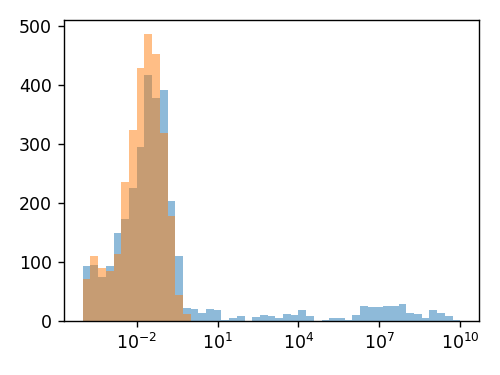

In [65]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(gradh_CH4_nr.U_1.ravel()), bins=np.logspace(np.log10(1e-4), np.log10(1e10), 50), alpha=0.5)
ax.hist(abs(gradh_CH4.U_1.ravel()), bins=np.logspace(np.log10(1e-4), np.log10(1e10), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

我们确实会发现，蓝色的条甚至可以延伸到 $10^{10}$ 量级。经过后文的叙述，我们应当能知道，由于甲烷分子具有 $T_d$ 对称性，因此存在三维不可约表示下的简并轨道，导致 $U_{ij}^{A_t}$ 或 $U_{ab}^{A_t}$ 计算式中，处在分母的 $\varepsilon_i - \varepsilon_j$ 或 $\varepsilon_a - \varepsilon_b$ 为零，从而产生巨大的数值问题。

In [66]:
gradh_CH4.e

array([-11.20416,  -0.94871,  -0.54481,  -0.54481,  -0.54481,   0.25607,   0.32516,   0.32516,   0.32516,   0.7408 ,   0.7408 ,   0.7408 ,   1.23234,
         1.23234,   1.23234,   1.25106,   1.32904])

而非对称的双氧水分子对称性较低，因此不会产生如此大的数值问题；但即使如此，若我们现在增大基组，则会增加大量的空轨道，从而缩小许多 $\varepsilon_a - \varepsilon_b$ 的值，进而数值问题也会越严重。因此，即使非对称双氧水不具有高对称性，也仍然需要避免在实际计算中使用 $U_{ij}^\mathbb{A}$ 或 $U_{ab}^\mathbb{A}$，而应用 $S_{pq}^\mathbb{A}$ 或 $\mathscr{U}_{pq}^\mathbb{A}$ 替代。

### 任务 (2)

待证明等式是

$$
\begin{align}
\frac{\partial F_{\mu \nu}}{\partial A_t}
&= 2 \left( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa | \nu \lambda) \right) \big( C_{\kappa m} C_{\lambda i} + C_{\kappa i} C_{\lambda m} \big) U_{mi}^{A_t} \\
&= \big( 4 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) - (\mu \lambda | \kappa \nu) \big) C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
\end{align}
$$

首先，我们需要知道上面式子是对 $\kappa, \lambda, m, i$ 四个角标求和。我们将第一行的待证式拆开来写为 (非 Einstein Summation)

$$
\sum_{\kappa \lambda m i} \big( 2 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) \big) C_{\kappa m} C_{\lambda i} U_{mi}^{A_t} + \sum_{\kappa \lambda m i} \big( 2 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) \big) C_{\kappa i} C_{\lambda m} U_{mi}^{A_t}
$$

保持上式第一项不动，第二项交换角标 $\kappa, \lambda$ 得到

$$
\sum_{\lambda \kappa m i} \big( 2 (\mu \nu | \lambda \kappa) - (\mu \lambda | \nu \kappa) \big) C_{\lambda i} C_{\kappa m} U_{mi}^{A_t}
$$

我们注意到，此时两项都有相同的公因式 $C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}$ 可以提出来；剩下的部分相加即可：

$$
\sum_{\kappa \lambda m i} \big( 2 (\mu \nu | \kappa \lambda) + 2 (\mu \nu | \lambda \kappa) - (\mu \kappa | \nu \lambda) - (\mu \lambda | \nu \kappa) \big) C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
$$

我们注意到原子轨道具有对称性，因此 $(\mu \nu | \kappa \lambda) = (\mu \nu | \lambda \kappa)$，以及 $(\mu \lambda | \kappa \nu)$；因此，上式可以写为

$$
\sum_{\kappa \lambda m i} \big( 4 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) - (\mu \lambda | \kappa \nu) \big) C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
$$

这就是待证等式的第二行了。

### 任务 (3)

待证等式是

$$
\frac{\partial F_{pq}}{\partial {A_t}} = F_{pq}^{A_t} + A_{pq, mi} U_{mi}^{A_t} + F_{pm} U_{mq}^{A_t} + F_{mq} U_{mp}^{A_t}
$$

我们的推导前提是

$$
\frac{\partial F_{\mu \nu}}{\partial A_t} = F_{\mu \nu}^{A_t} + A_{\mu \nu, \kappa \lambda} C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
$$

首先，通过 $F_{pq} = C_{\mu p} F_{\mu \nu} C_{\nu q}$ 我们知道

$$
\frac{\partial F_{pq}}{\partial {A_t}} = C_{\mu p} \frac{\partial F_{\mu \nu}}{\partial A_t} C_{\nu q} + F_{pm} U_{mq}^{A_t} + F_{mq} U_{mp}^{A_t}
$$

其中，

$$
\begin{align}
C_{\mu p} \frac{\partial F_{\mu \nu}}{\partial A_t} C_{\nu q}
&= C_{\mu p} F_{\mu \nu}^{A_t} C_{\nu q} + C_{\mu p} C_{\nu q} A_{\mu \nu, \kappa \lambda} C_{\kappa m} C_{\lambda i} U_{mi}^{A_t} \\
&= F_{pq}^{A_t} + A_{pq, mi} U_{mi}^{A_t}
\end{align}
$$

证明完毕。

### 任务 (4)

我们要求取的全导数为

$$
\frac{\partial F_{pq}}{\partial {A_t}} = F_{pq}^{A_t} + A_{pq, mi} U_{mi}^{A_t} + F_{pm} U_{mq}^{A_t} + F_{mq} U_{mp}^{A_t}
$$

解析导数我们记为 `d_F_0_mo` $\partial_{A_t} F_{pq}$：

In [67]:
d_F_0_mo = (
    + F_1_mo
    + np.einsum("pqmi, Atmi -> Atpq", A_0_mo[:, :, :, so], to_natm_3(gradh_nr.U_1)[:, :, :, so])
    + np.einsum("pm, Atmq -> Atpq", F_0_mo, to_natm_3(gradh_nr.U_1))
    + np.einsum("mq, Atmp -> Atpq", F_0_mo, to_natm_3(gradh_nr.U_1))
)

数值导数我们记为 `nd_F_0_mo`：

In [68]:
nd_F_0_mo = NumericDiff(gradn, lambda gradh: gradh.F_0_mo).derivative.reshape(natm, 3, nao, nao)

但比较有意思的是，这次我们不能简单地通过查看图像来判断是否上述数值与解析导数是一致的：

<IPython.core.display.Javascript object>


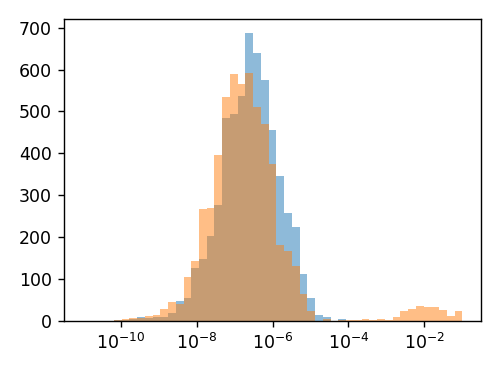

In [69]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(d_F_0_mo.ravel() - nd_F_0_mo.ravel()), bins=np.logspace(np.log10(1e-11), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_F_0_mo.ravel()), bins=np.logspace(np.log10(1e-11), np.log10(1e-1), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

这是因为，$\partial F_{pq} = \varepsilon_p \delta_{pq}$，因此所有非对角元都会是零值；其导数也不例外。因此，若要验证我们计算出来的解析导数，需要做两件事。

首先是判断非对角元是否近乎为零。我们先构造一个 `delta_Atpq` $\delta_{pq}^{A_t}$，它会用来去除对角元的干扰；随后我们计算其余矩阵元的平均绝对值。

In [70]:
delta_Atpq = np.eye(nmo).reshape(1, nmo, nmo).repeat(natm * 3, axis=0).reshape(natm, 3, nmo, nmo)
print("Average:", abs(d_F_0_mo * (1 - delta_Atpq)).sum() / (natm * 3 * nmo * (nmo - 1)))
print("Maximum:", np.max(d_F_0_mo * (1 - delta_Atpq)))

Average: 4.614724541799558e-07
Maximum: 6.678304349949649e-05


其次再是判断对角元是否接近。我们活用 np.diagonal 函数来查看情况：

<IPython.core.display.Javascript object>


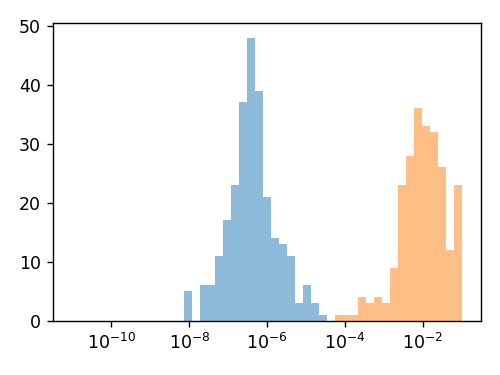

In [71]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(abs(d_F_0_mo.diagonal(axis1=-2, axis2=-1).ravel() - nd_F_0_mo.diagonal(axis1=-2, axis2=-1).ravel()), bins=np.logspace(np.log10(1e-11), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_F_0_mo.diagonal(axis1=-2, axis2=-1).ravel()), bins=np.logspace(np.log10(1e-11), np.log10(1e-1), 50), alpha=0.5)
ax.set_xscale("log")
fig.tight_layout()

### 任务 (5)

我们需要利用的函数 `resp` 定义如下：

$$
\mathtt{resp}_{\mu \nu} [X_{\kappa \lambda}^\mathbb{A}] = \big( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa| \nu \lambda) \big) X_{\kappa \lambda}^\mathbb{A}
$$

In [72]:
resp = _gen_rhf_response(gradh.scf_eng, mo_coeff=C, mo_occ=gradh.mo_occ, hermi=0)

而原子轨道下的 A 矩阵定义如下：

$$
A_{\mu \nu, \kappa \lambda} = 4 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda) - (\mu \lambda | \kappa \nu)
$$

现在我们考虑

$$
\begin{align}
\mathtt{resp}_{\mu \nu} [X_{\kappa \lambda}^\mathbb{A} + X_{\lambda \kappa}^\mathbb{A}]
&= \big( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa| \nu \lambda) \big) X_{\kappa \lambda}^\mathbb{A} + \big( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa| \nu \lambda) \big) X_{\lambda \kappa}^\mathbb{A} \\
&= \big( (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa| \nu \lambda) \big) X_{\kappa \lambda}^\mathbb{A} + \big( (\mu \nu | \lambda \kappa) - \frac{1}{2} (\mu \lambda| \nu \kappa) \big) X_{\kappa \lambda}^\mathbb{A} \\
&= \big( 2 (\mu \nu | \kappa \lambda) - \frac{1}{2} (\mu \kappa| \nu \lambda) - \frac{1}{2} (\mu \lambda| \nu \kappa) \big) X_{\kappa \lambda}^\mathbb{A} \\
&= \frac{1}{2} A_{\mu \nu, \kappa \lambda} X_{\kappa \lambda}^\mathbb{A}
\end{align}
$$

从而，

$$
\begin{align}
A_{pq, mi} U_{mi}^\mathbb{A}
&= C_{\mu p} C_{\nu q} A_{\mu \nu, \kappa \lambda} C_{\kappa m} C_{\lambda i} U_{mi}^\mathbb{A} \\
&= 2 C_{\mu p} C_{\nu q} \mathtt{resp}_{\mu \nu} [C_{\kappa m} C_{\lambda i} U_{mi}^\mathbb{A} + C_{\lambda m} C_{\kappa i} U_{mi}^\mathbb{A}]
\end{align}
$$

我们下面就计算 $2 C_{\mu p} C_{\nu q} [C_{\kappa m} C_{\lambda i} U_{mi}^\mathbb{A} + \mathrm{swap} (\kappa, \lambda)]$。首先我们会定义一个临时变量 `dmU` $U_{\kappa \lambda}^{A_t}$：

$$
U_{\kappa \lambda}^{A_t} = C_{\kappa m} U_{mi}^{A_t} C_{\lambda i} + \mathrm{swap} (\kappa, \lambda)
$$

In [73]:
dmU = np.einsum("km, Atmi, li -> Atkl", C, to_natm_3(gradh_nr.U_1[:, :, so]), Co)
dmU += dmU.swapaxes(-1, -2)

随后，我们就可以求取 $A_{pq, mi} U_{mi}^{A_t}$。用 `resp` 函数求取的结果我们记在 `AU_nr_resp` 中；但需要注意到，输入给 `resp` 的张量必须是只有三个维度的：

In [74]:
AU_nr_resp = 2 * np.einsum("up, vq, Atuv -> Atpq", C, C, to_natm_3(resp(dmU.reshape(natm * 3, nao, nao))))

最后我们验证一下上述计算是否正确。我们直接对 `A_0_mo[:, :, :, so]` $A_{pq, mi}$ 与 `to_natm_3(gradh_nr.U_1[:, :, so]))` $U_{mi}^{A_t}$ 作张量缩并即可：

In [75]:
np.allclose(AU_nr_resp, np.einsum("pqmi, Atmi -> Atpq", A_0_mo[:, :, :, so], to_natm_3(gradh_nr.U_1[:, :, so])))

True

### 任务 (6)

待证等式是

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = F_{pq}^\mathbb{A} - S_{pq}^\mathbb{A} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A} + A_{pq, bj} U_{bj}^\mathbb{A} + (\varepsilon_p - \varepsilon_q) U_{pq}^\mathbb{A}
$$

证明前提是

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = F_{pq}^\mathbb{A} + A_{pq, mi} U_{mi}^\mathbb{A} + F_{pm} U_{mq}^\mathbb{A} + F_{mq} U_{mp}^\mathbb{A}
$$

我们先看后面两项。根据 $F_{pq} = \varepsilon_p \delta_{pq}$，后两项有

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} \leftarrow F_{pm} U_{mq}^\mathbb{A} + F_{mq} U_{mp}^\mathbb{A} = \varepsilon_p U_{pq}^\mathbb{A} + \varepsilon_q U_{qp}^\mathbb{A}
$$

利用 $U_{pq}^\mathbb{A} + U_{qp}^\mathbb{A} + S_{pq}^\mathbb{A} = 0$，我们能推出 $U_{qp}^\mathbb{A} = - S_{pq}^\mathbb{A} - U_{pq}^\mathbb{A}$；因此上式化为

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} \leftarrow (\varepsilon_p - \varepsilon_q) U_{pq}^\mathbb{A} - S_{pq}^\mathbb{A} \varepsilon_q
$$

我们再看 $A_{pq, mi} U_{mi}^\mathbb{A}$ 一项。我们拆开 $m$ 作为占据轨道与非占轨道的情况，给出

$$
\begin{align}
\frac{\partial F_{pq}}{\partial \mathbb{A}} \leftarrow A_{pq, mi} U_{mi}^\mathbb{A}
&= A_{pq, kl} U_{kl}^\mathbb{A} + A_{pq, bj} U_{bj}^\mathbb{A} \\
&= \frac{1}{2} (A_{pq, kl} U_{kl}^\mathbb{A} + A_{pq, lk} U_{lk}^\mathbb{A}) + A_{pq, bj} U_{bj}^\mathbb{A} \\
&= \frac{1}{2} A_{pq, kl} (U_{kl}^\mathbb{A} + U_{lk}^\mathbb{A}) + A_{pq, bj} U_{bj}^\mathbb{A} \\
&= - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A} + A_{pq, bj} U_{bj}^\mathbb{A}
\end{align}
$$

上述证明过程中，第二个等号利用到 $k, l$ 角标可交换；第三个等号利用到 A 张量的对称性 $A_{pq, kl} = A_{pq, lk}$；第四个等号利用到的是 $U_{pq}^\mathbb{A} + U_{qp}^\mathbb{A} + S_{pq}^\mathbb{A} = 0$。

至此就证明完毕了。下面我们通过待证等式的等式右生成 $\partial_{A_t} F_{pq}$，生成的结果放在 `d_F_0_mo_simp` 中：

$$
\frac{\partial F_{pq}}{\partial A_t} = F_{pq}^\mathbb{A} - S_{pq}^{A_t} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^{A_t} + A_{pq, bj} U_{bj}^{A_t} + (\varepsilon_p - \varepsilon_q) U_{pq}^{A_t}
$$

In [76]:
d_F_0_mo_simp = (
    + F_1_mo
    - S_1_mo * e
    - 0.5 * Ax0_Core(sa, sa, so, so)(S_1_mo[:, :, so, so])
    + Ax0_Core(sa, sa, sv, so)(to_natm_3(gradh_nr.U_1_vo))
    + (e[:, None] - e[None, :]) * (to_natm_3(gradh_nr.U_1))
)

我们在任务 (4) 中已经生成过 `d_F_0_mo` $\partial_{A_t} F_{pq}$；我们可以核验这两者是否等价：

In [77]:
np.allclose(d_F_0_mo_simp, d_F_0_mo, atol=1e-5)

True

### 任务 (7)

我们求取的目标 `U_1_vv` $U_{ab}^{A_t}$ 为

$$
\begin{equation}
\left\{
\begin{matrix}
U_{ab}^\mathbb{A} &= - \frac{B_{ab}^\mathbb{A} + A_{ab, ck} U_{ck}^\mathbb{A}}{\varepsilon_a - \varepsilon_b} &\quad (a \neq b) \\
U_{aa}^\mathbb{A} &= - \frac{1}{2} S_{aa}^\mathbb{A}
\end{matrix}
\right.
\end{equation}
$$

In [78]:
U_1_vv = - (B_1[:, :, sv, sv] + Ax0_Core(sv, sv, sv, so)(U_1_ai)) / (ev[:, None] - ev[None, :])
for p in range(nocc, nmo):
    U_1_vv[:, :, p - nocc, p - nocc] = - S_1_mo[:, :, p, p] / 2
U_1_vv.shape

(4, 3, 13, 13)

我们验证一下是否与 pyxdh 的结果一致：

In [79]:
np.allclose(U_1_vv.ravel(), gradh_nr.U_1[:, sv, sv].ravel())

True